# Male or Female?

The goal of this notebook is to use `fastai` to fine-tune a vision model that will distinguish between photos of men and females. Steps:

1. [x] Use `DuckDuckGo` to search for and acquire portrait photos of men.
2. [x] Use `DuckDuckGo` to search for and acquire portrait photos of women.
3. [x] Fine-tune `resnet18` to distinguish between the two categories.
4. [x] Try running the model on a picture of a man and a woman to see if it works.

Let's start by importing a few essential libraries:

In [1]:
%load_ext autoreload
%autoreload 2
%pdb on 

Automatic pdb calling has been turned ON


In [39]:
import os
import shutil
import imghdr
import hashlib
import requests
import jupyter_plz
from tqdm import tqdm
from typing import List
from pathlib import Path
from random import shuffle
from PIL import Image as PilImg
from IPython.display import Image as IPyImg
from IPython.core.debugger import set_trace
from multiprocessing.pool import ThreadPool
from concurrent.futures import as_completed

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

We import the `DuckDuckGo-search` library that we are going to use to source the images: 

In [4]:
from duckduckgo_search import ddg_images
from fastai.data.all import *
from fastai.vision.all import *

# Data Collection

Let's start by creating the data `store` and `train` and `test` directories:

In [5]:
store = Path("./store")
shutil.rmtree(store)

In [6]:
train_dir = store / "train/"
test_dir = store / "test/"
train_dir.mkdir(exist_ok=True, parents=True)
test_dir.mkdir(exist_ok=True, parents=True)

Let's get some images for men:

In [7]:
# Set search parameters
keywords = "female portrait"
num_imgs = 1

# Search
images = ddg_images(keywords, max_results=num_imgs)

# Get the URLs
images = [("".join(img["image"].split("?")[:-1]) if "?" in img["image"] else img["image"]) for img in images if "image" in img.keys()]

Let's take a look at the image:

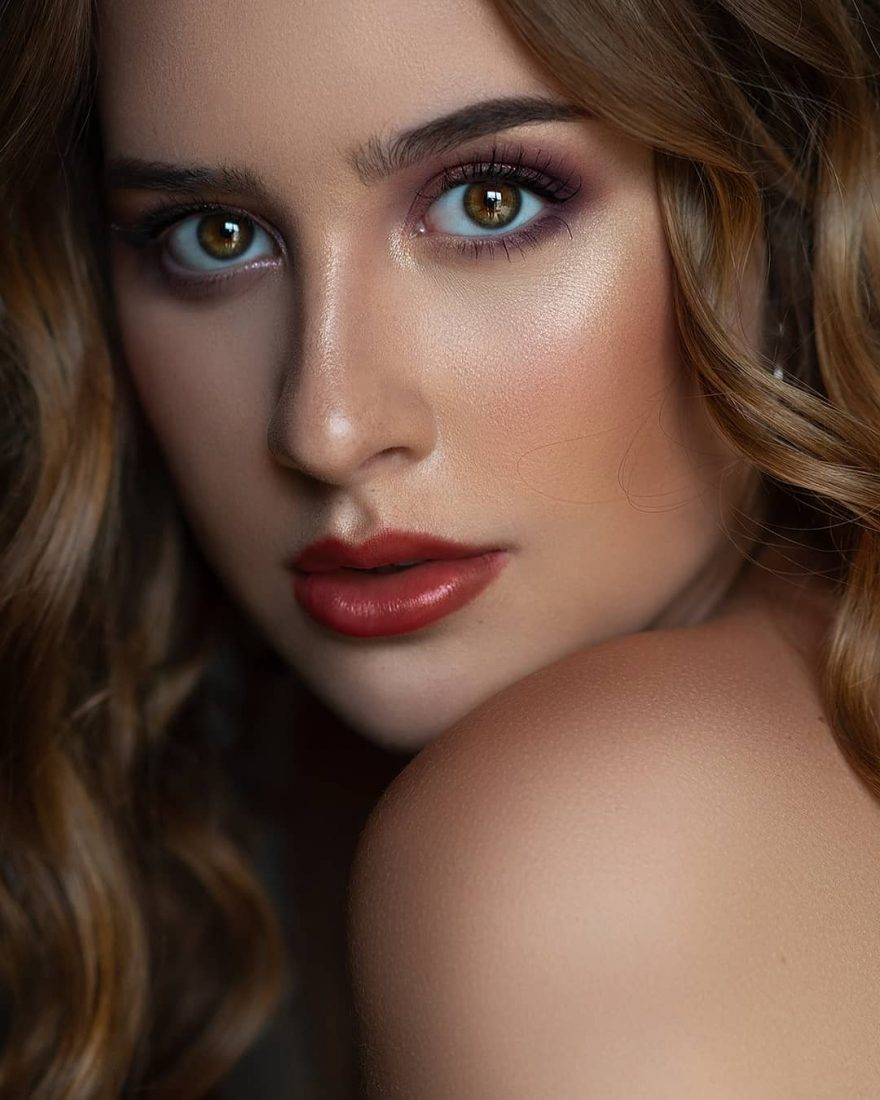

In [8]:
IPyImg(images[0], width=100)

In [9]:
def save_images(urls: List[str], directory: Path) -> None:
    directory.mkdir(exist_ok=True)
    def download_image(url):
        try:
            res = requests.get(url, stream=True)
            if res.status_code == 200:
                if 'Content-Type' in res.headers and imghdr.what(None, h=res.content) is not None:
                    file_name = os.path.basename(url)
                    extension = os.path.splitext(file_name)[1]
                    if len(file_name) > 250:
                        file_name = hashlib.sha1(file_name.encode()).hexdigest() + extension
                    file_path = os.path.join(directory, file_name)
                    with open(file_path, 'wb') as f:
                        for chunk in res.iter_content(1024):
                            f.write(chunk)
                else:
                    # Image is not valid, do not save it
                    pass
        except:
            pass
    with ThreadPool(25) as executor:
        for _ in executor.map(download_image, urls):
            pass

We create the male and female directories:

In [10]:
# Create the two directories
for dir_ in [train_dir, test_dir]:
    
    males_dir = dir_ / "male"
    females_dir = dir_ / "female"

    males_dir.mkdir(exist_ok=True)
    females_dir.mkdir(exist_ok=True)

Let's download 200 images for both men and women:

In [11]:
# Men
train_males = ddg_images("male portrait", max_results=200)
train_males = [("".join(img["image"].split("?")[:-1]) if "?" in img["image"] else img["image"]) for img in train_males if "image" in img.keys()]

# Women
train_females = ddg_images("female portrait", max_results=200)
train_females = [("".join(img["image"].split("?")[:-1]) if "?" in img["image"] else img["image"]) for img in train_females if "image" in img.keys()]

# Add 10 men + one female pics to the test set
test_males, test_females = list(), list()
for _ in range(10):
    test_males.append(train_males.pop())
    test_females.append(train_females.pop())

Now we download:

In [12]:
save_images(train_females, train_dir / "female")
save_images(train_males, train_dir / "male")
save_images(test_males, test_dir / "male")
save_images(test_females, test_dir / "female")

Next, we need to resize all images:

In [13]:
# Get all paths
l1 = list((train_dir / "female").glob("**/*"))
l2 = list((train_dir / "male").glob("**/*"))
l3 = list((test_dir / "female").glob("**/*"))
l4 = list((test_dir / "male").glob("**/*"))
files = l1 + l2 + l3 + l4
len(files)

343

In [14]:
def resize_image(file_path, new_width):
    try:
        # open the image
        image = Image.open(file_path)
        
        # get the current width and height
        width, height = image.size
        
        # calculate the new height
        new_height = int(height * (new_width / width))
        
        # resize the image
        resized_image = image.resize((new_width, new_height))
        
        # save the resized image
        resized_image.save(file_path)
    except:
        # In case something breaks and we couldn't resize the image, remove it.
        file_path.unlink()

In [15]:
_ = list(map(lambda p: resize_image(p, 400), files))

# Modeling with `FastAI`

Let's move now to modeling with `fastai`:

In [16]:
# Create the data block (abstract)
gender_block = DataBlock(blocks=(ImageBlock, CategoryBlock),
                         get_items=get_image_files,
                         splitter=RandomSplitter(valid_pct=0.2, seed=234),
                         get_y=parent_label,
                         item_tfms=Resize(224, method="crop"))

In [17]:
# Get the corresponding fastai data loaders
data_loaders = gender_block.dataloaders(train_dir, bs=8)

Let's visualize a single sample batch:

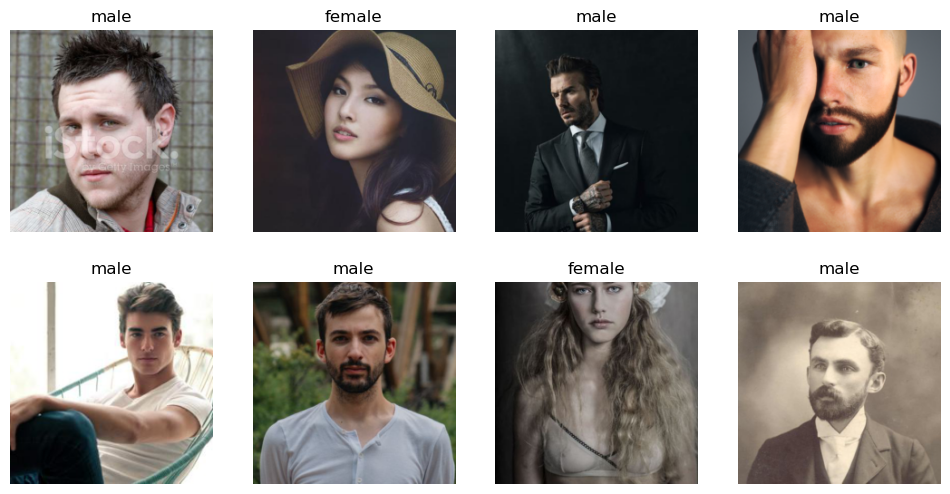

In [18]:
data_loaders.show_batch()

I guess we are ready to fine-tune a `resnet18` on our data loaders:

In [19]:
learn = vision_learner(data_loaders, 
                       resnet18, 
                       metrics=error_rate)

/Users/akramz/miniconda3/envs/learn_fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/akramz/miniconda3/envs/learn_fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.816314,0.201097,0.081967,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.325093,0.165925,0.049180,00:15
1,0.282173,0.114068,0.032787,00:16
2,0.226807,0.188879,0.081967,00:16
3,0.242443,0.175844,0.065574,00:17
4,0.248822,0.228747,0.049180,00:19
5,0.188291,0.190349,0.049180,00:19
6,0.197479,0.183657,0.049180,00:18
7,0.217217,0.160923,0.065574,00:17
8,0.186302,0.189766,0.081967,00:17
9,0.161314,0.151358,0.065574,00:19


We now predict for the test set:

In [42]:
test_males = [("male", f) for f in list((test_dir / "male").glob("**/*"))]
test_females = [("female", f) for f in list((test_dir / "female").glob("**/*"))]
test_points = test_males + test_females
shuffle(test_points)

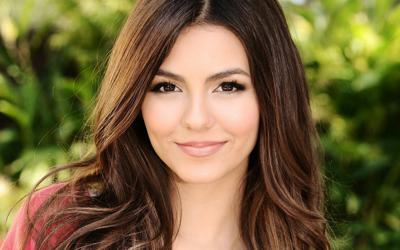

Actual: female. Prediction: female
 ------------------ 



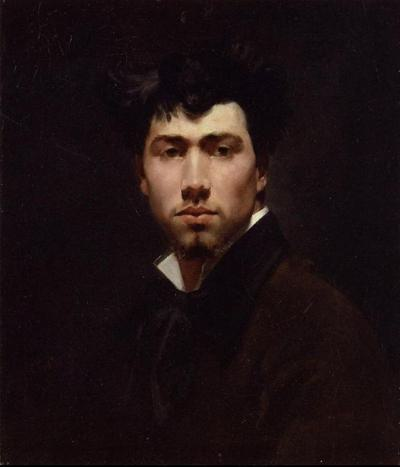

Actual: male. Prediction: male
 ------------------ 



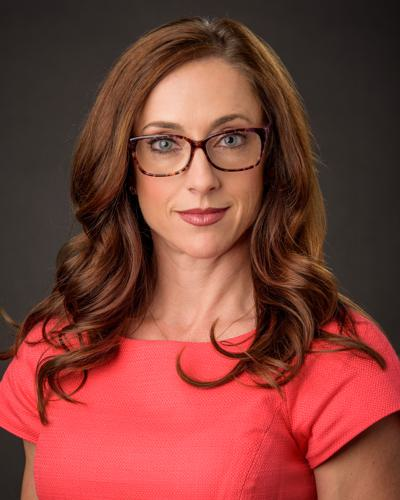

Actual: female. Prediction: female
 ------------------ 



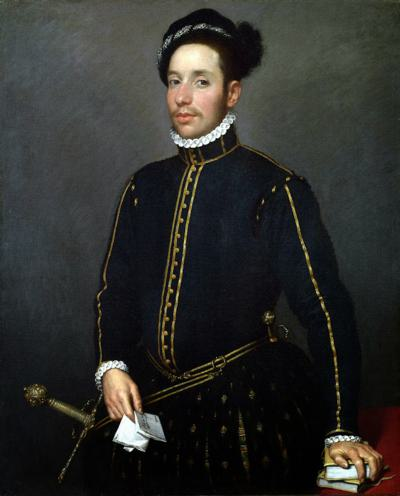

Actual: male. Prediction: male
 ------------------ 



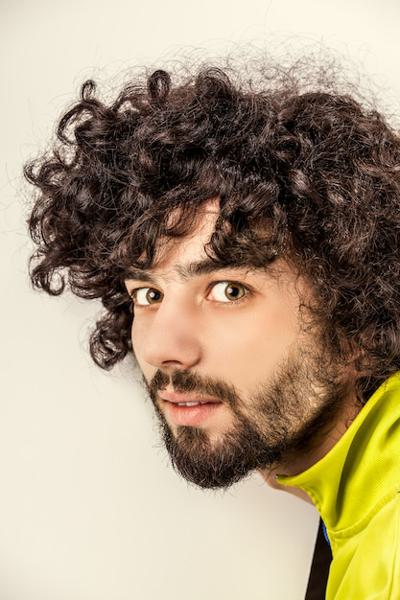

Actual: male. Prediction: male
 ------------------ 



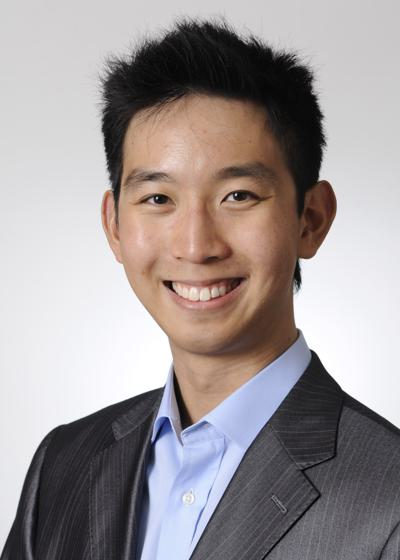

Actual: male. Prediction: male
 ------------------ 



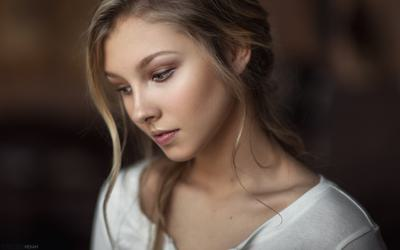

Actual: female. Prediction: female
 ------------------ 



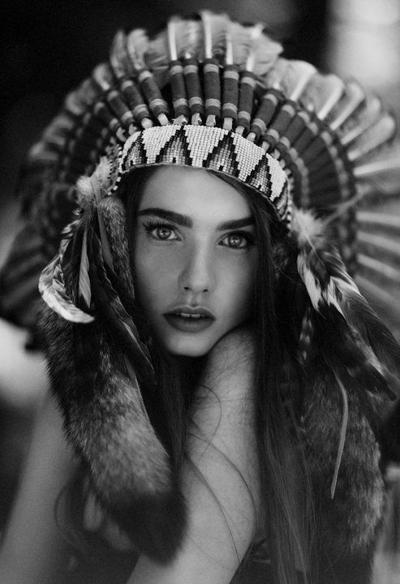

Actual: female. Prediction: female
 ------------------ 



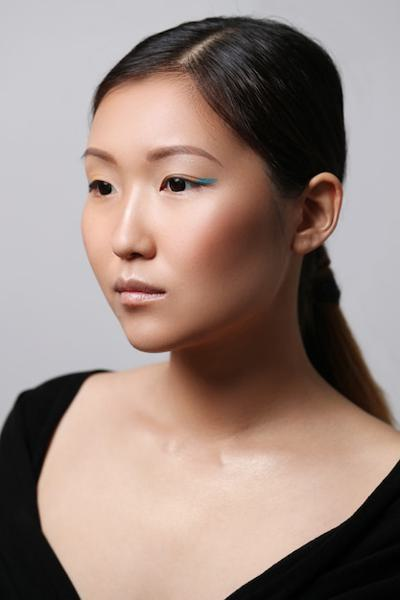

Actual: female. Prediction: female
 ------------------ 



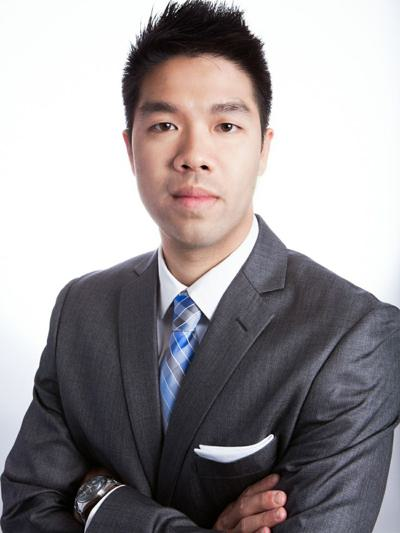

Actual: male. Prediction: male
 ------------------ 



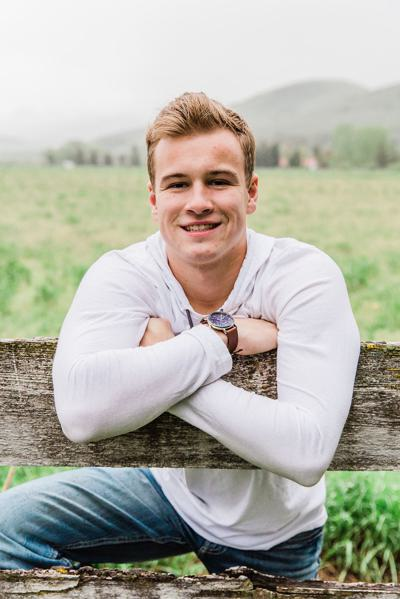

Actual: male. Prediction: male
 ------------------ 



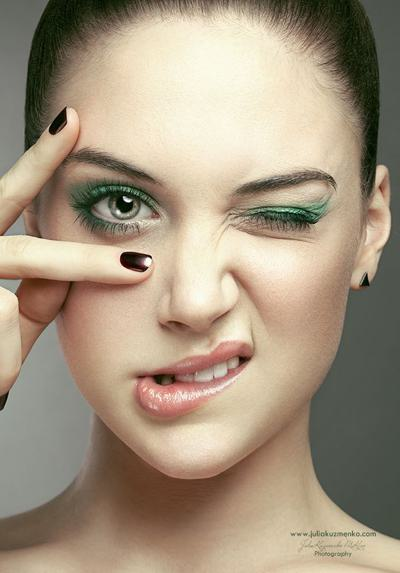

Actual: female. Prediction: female
 ------------------ 



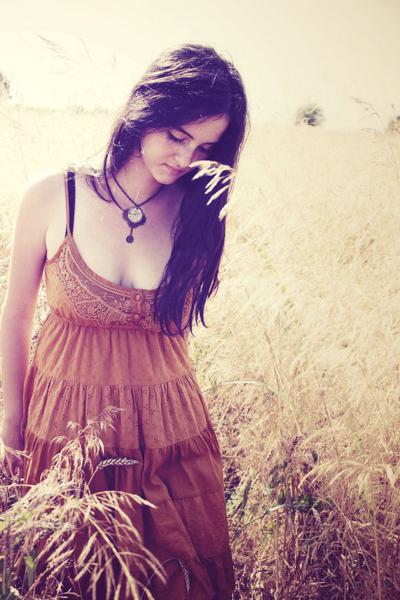

Actual: female. Prediction: female
 ------------------ 



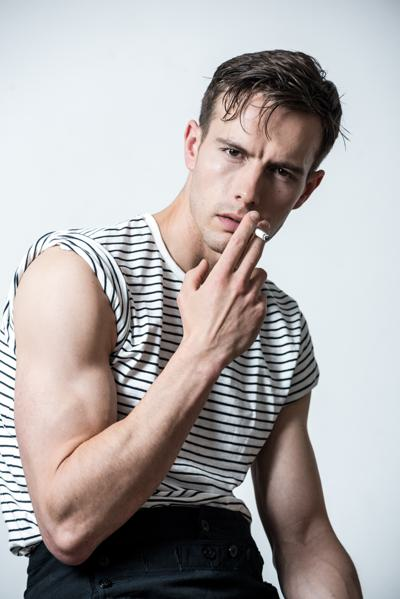

Actual: male. Prediction: male
 ------------------ 



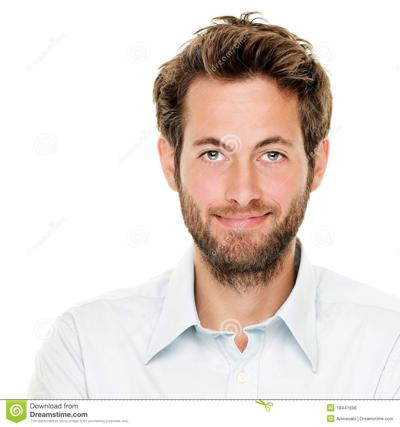

Actual: male. Prediction: male
 ------------------ 



In [50]:
for y, file_path in test_points:
    display(IPyImg(file_path, width=100))
    y_hat, _, _ = learn.predict(item=file_path)
    print(f"Actual: {y}. Prediction: {y_hat}\n ------------------ \n")

---